**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import time
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, skew, kurtosis

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

/kaggle/input/sample_submission.csv
/kaggle/input/sample_submission.csv.gz
/kaggle/input/train.csv.gz
/kaggle/input/data_description.txt
/kaggle/input/test.csv.gz
/kaggle/input/train.csv
/kaggle/input/test.csv


Here's some of the code you've written so far. Start by running it again.

In [2]:
train = pd.read_csv('../input/train.csv', index_col= 'Id')
test = pd.read_csv('../input/test.csv', index_col = 'Id')

X = pd.concat([train.iloc[:, :-1], test])
y = train.iloc[:, -1]

In [3]:
# personally, interactive plots are my bests, and so, sns.heatmap() not used

import plotly.express as px

px.imshow(train.corr(),
         template = 'plotly_white',
         height = 800, width = 800)


#### Correlated pairs:
GarageCars - GarageArea / GrLivArea - TotRmsAbvGrd / Yearbuilt - GarageYrBlt


In [4]:
X.drop(['GarageYrBlt','TotRmsAbvGrd','GarageCars'], axis = 1, inplace=True)

In [5]:
# to count missing values

na_counts = pd.DataFrame(X.isnull().sum().sort_values(ascending = False), columns = ['na_counts'])
na_counts['NA%'] = na_counts['na_counts'].apply(lambda x: x/X.shape[0] * 100).round(2)
na_counts.head(20)

na_counts    NA%
PoolQC             2909  99.66
MiscFeature        2814  96.40
Alley              2721  93.22
Fence              2348  80.44
FireplaceQu        1420  48.65
LotFrontage         486  16.65
GarageFinish        159   5.45
GarageQual          159   5.45
GarageCond          159   5.45
GarageType          157   5.38
BsmtExposure         82   2.81
BsmtCond             82   2.81
BsmtQual             81   2.77
BsmtFinType2         80   2.74
BsmtFinType1         79   2.71
MasVnrType           24   0.82
MasVnrArea           23   0.79
MSZoning              4   0.14
Functional            2   0.07
BsmtFullBath          2   0.07

In [6]:
# the first four will be dropped due to high missing values ratios

X.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis =1, inplace=True)

In [7]:
#remove features that does not really contribute to target SalePrice

X.drop(['MoSold', 'YrSold'], axis = 1, inplace=True)

In [8]:
# to deal with other NAs depending on their types: categorial or numerical

#MSSubClass is nominal

X['MSSubClass'] = X['MSSubClass'].astype('str')

In [9]:
cat_list = []
num_list = []

for var in X.columns:
    if X[var].dtype == 'object':
        cat_list.append(var)
    else:
        num_list.append(var)

# higly skewed categorical variables (>95%) are dropped

cat_drop_list = []

for var in cat_list:
    ratio = X[var].value_counts().iloc[0]/X.shape[0] * 100
    if ratio > 95:
        cat_drop_list.append(var)
        
print(cat_drop_list)
X.drop(cat_drop_list,axis = 1,inplace=True)

# for numerical variables that are highly skewed, try to make them Gaussian-like by box-cox transformation

num_trans_list = []

for var in num_list:
    ratio = X[var].value_counts().iloc[0]/X.shape[0] * 100
    if ratio > 95:
        num_trans_list.append(var)
        
print(num_trans_list)
for var in num_trans_list:
    X[var] = boxcox1p(X[var], boxcox_normmax(X[var] + 1))

['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating']
['LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal']


In [10]:
# to deal with outliers (that are in the train dataset, do not touch test dataset to avoid data leakage, of course)
# it is easy to determine the range of outliers with the aid of interactive graphs
# for a tight layout, plotly.graph_objects is avaialble coz it can create subplots

for var in num_list:
    fig = px.box(train, var,
                width = 400, height = 250)

In [11]:
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea']> 100000].index)
train = train.drop(train[train['MasVnrArea'] > 1200].index)
train = train.drop(train[train['BsmtUnfSF'] > 2000].index)
train = train.drop(train[train['2ndFlrSF'] > 2000].index)
train = train.drop(train[train['GarageArea'] > 1130].index)
train = train.drop(train[train['WoodDeckSF'] > 600].index)
train = train.drop(train[train['OpenPorchSF'] > 400].index)
train = train.drop(train[train['BsmtFinSF1'] > 3000].index)
train = train.drop(train[train['TotalBsmtSF'] > 4000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)

In [12]:
# to double-check missing values

na_counts = pd.DataFrame(X.isnull().sum().sort_values(ascending = False), columns = ['na_counts'])
na_counts['NA%'] = na_counts['na_counts'].apply(lambda x: x/X.shape[0] * 100).round(2)

na_counts.head(15)

na_counts    NA%
FireplaceQu        1420  48.65
LotFrontage         486  16.65
GarageCond          159   5.45
GarageQual          159   5.45
GarageFinish        159   5.45
GarageType          157   5.38
BsmtExposure         82   2.81
BsmtCond             82   2.81
BsmtQual             81   2.77
BsmtFinType2         80   2.74
BsmtFinType1         79   2.71
MasVnrType           24   0.82
MasVnrArea           23   0.79
MSZoning              4   0.14
BsmtFullBath          2   0.07

In [13]:
# to sort missing data by type

num_list = []
cat_list = []

for var in na_counts.index:
    if na_counts['na_counts'][var] > 0:
        if X[var].dtype != 'object':
            num_list.append(var)
        else:
            cat_list.append(var)
        
print(num_list)
print('\t')
print(cat_list)

['LotFrontage', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'GarageArea']
	
['FireplaceQu', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MSZoning', 'Functional', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical', 'Exterior1st']


In [14]:
# for ordinal variables
# There are some columns which are ordinal by nature, which represents the quality or condition of certain housing features. 
# In this case, we will map the respective strings to a value. The better the quality, the higher the value

ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}

ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
X[ord_col] = X[ord_col].fillna('NA')

for var in ord_col:
    X[var] = X[var].map(ordinal_map)
    
BsmtFin_col = ['BsmtFinType1','BsmtFinType2']
X[BsmtFin_col] = X[BsmtFin_col].fillna('NA')
for var in BsmtFin_col:
    X[var] = X[var].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].fillna('NA')
X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)

In [15]:
# for numerical variables

neigh_lot = X.groupby('Neighborhood')['LotFrontage'].median().reset_index(name = 'LotFrontage_median') 
neigh_garage = X.groupby('Neighborhood')['GarageArea'].median().reset_index(name = 'GarageArea_median')

fig1 = px.bar(neigh_lot, x = 'Neighborhood', y = 'LotFrontage_median',
      height = 400, width = 800)

fig2 = px.bar(neigh_garage, x = 'Neighborhood', y = 'GarageArea_median',
      height = 400, width = 800)

In [16]:
# lot frontage and garage area medians are correlated to neighborhood, so fill their nas using respective medians

X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.median()))

In [17]:
# to fill na using median for the rest of numerical variables

for var in ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]:
    X[var] = X[var].fillna(X[var].median())

In [18]:
na_counts = pd.DataFrame(X.isnull().sum().sort_values(ascending = False), columns = ['na_counts'])
na_counts['NA%'] = na_counts['na_counts'].apply(lambda x: x/X.shape[0] * 100).round(2)

na_counts.head(12)

na_counts   NA%
GarageFinish        159  5.45
GarageType          157  5.38
MasVnrType           24  0.82
MSZoning              4  0.14
Functional            2  0.07
Electrical            1  0.03
Exterior1st           1  0.03
Exterior2nd           1  0.03
SaleType              1  0.03
BsmtHalfBath          0  0.00
FullBath              0  0.00
Fireplaces            0  0.00

In [19]:
num_list = []
cat_list = []

for var in na_counts.index:
    if na_counts['na_counts'][var] > 0:
        if X[var].dtype != 'object':
            num_list.append(var)
        else:
            cat_list.append(var)
        
print(num_list)
print('\t')
print(cat_list)

[]
	
['GarageFinish', 'GarageType', 'MasVnrType', 'MSZoning', 'Functional', 'Electrical', 'Exterior1st', 'Exterior2nd', 'SaleType']


In [20]:
# for categorical variables

X['GarageFinish'] = X['GarageFinish'].fillna('NA')
X['GarageType'] = X['GarageType'].fillna('NA')

In [21]:
# to fill missing values (categorical variables) with mode

cat_col = ['MasVnrType', 'MSZoning', 'Functional', 'Exterior2nd', 'Exterior1st', 'Electrical', 'SaleType']

for var in cat_col:
    X[var] = X[var].fillna(X[var].mode().iloc[0])

In [22]:
na_counts = pd.DataFrame(X.isnull().sum().sort_values(ascending = False), columns = ['na_counts'])
na_counts['NA%'] = na_counts['na_counts'].apply(lambda x: x/X.shape[0] * 100).round(2)

na_counts.head(3)

# end of data imputation

na_counts  NA%
MSSubClass          0  0.0
MSZoning            0  0.0
Electrical          0  0.0

In [23]:
# feature engineering (by domain knowledge)

X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF'] + X['1stFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath'] * 0.5 + X['BsmtFullBath'] + X['BsmtHalfBath'] * 0.5
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF']

drop_list = [
    'LotFrontage', 'LotArea',
    'BsmtFinSF1', 'BsmtFinSF2',
    'TotalBsmtSF', '2ndFlrSF','1stFlrSF',
    'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath',
    'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF'
]

X.drop(drop_list,axis=1, inplace=True)

In [24]:
# binary columns

bin_col = ['MasVnrArea','TotalPorch','PoolArea', 'GarageQual', 'BsmtQual']

for var in bin_col:
    col_name = var + '_bin'
    X[col_name] = X[var].apply(lambda x: 1 if x > 0 else 0)

In [25]:
X = pd.get_dummies(X)

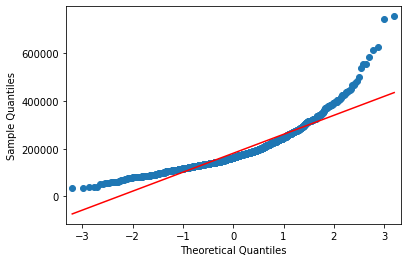

skewness: 1.881
kurtosis: 6.510


In [26]:
# to check the distribution of the target varaible

qqplot(y,line = 's')
plt.show()

print('skewness: %.3f' % (skew(y)))
print('kurtosis: %.3f' % (kurtosis(y)))

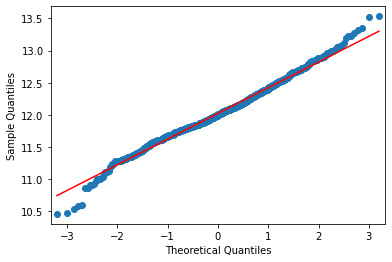

skewness: 0.121
kurtosis: 0.803


In [27]:
# the distribution is terribly off
# it is necessary to make y a bit Gaussian-like

qqplot(np.log1p(y),line = 's')
plt.show()

print('skewness: %.3f' % (skew(np.log1p(y))))
print('kurtosis: %.3f' % (kurtosis(np.log1p(y))))

In [28]:
# not that bad

y = y.apply(lambda x: np.log1p(x))

In [29]:
# training data preparation

x = X.loc[train.index]
y = y.loc[train.index]

In [30]:
# xgboost model

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedKFold
from xgboost import XGBRegressor

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', XGBRegressor(learning_rate = 0.1,
                                   max_depth = 6,
                                   min_child_weight = 10,
                                   subsample = 0.7,
                                   colsample_bytree= 1,
                                   reg_lambda = 1,
                                   gamma = 0.005,
                                   reg_alpha = 0.0005,
                                   n_estimators = 202)))

pipe_xgb = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_xgb, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.0797
STD: 0.0070
training time: 1898.21


In [31]:
# lightgbm model

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedKFold
from lightgbm import LGBMRegressor

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', LGBMRegressor(
    n_estimators = 1800,
    min_child_samples = 6,
    max_depth = 5,
    learning_rate = 0.01,
    lambda_l2 = 0.19,
    lambda_l1 = 0.04,
    feature_fraction = 0.25
)))

pipe_lgbm = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_lgbm, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.0751
STD: 0.0065
training time: 37.60


In [32]:
# catboost model

from catboost import CatBoostRegressor

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', CatBoostRegressor())) # the virgin model turned out to be the best one

pipe_cat = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_cat, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

[LightGBM] [Warning] lambda_l1 is set=0.04, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] lambda_l2 is set=0.19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19
[LightGBM] [Warning] lambda_l1 is set=0.04, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] lambda_l2 is set=0.19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19
[LightGBM] [Warning] lambda_l1 is set=0.04, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] lambda_l2 is set=0.19, reg_lambda=0.0 will be ignored. Current value: lamb

In [33]:
from sklearn.linear_model import ElasticNetCV

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', ElasticNetCV(cv = 3)))

pipe_en = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_en, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.0765
STD: 0.0065
training time: 6.10


In [34]:
from sklearn.linear_model import LassoCV

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', LassoCV(n_alphas = 207)))

pipe_lasso = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_lasso, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.0766
STD: 0.0065
training time: 13.05


In [35]:
from sklearn.linear_model import RidgeCV

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', RidgeCV(cv=7)))

pipe_ridge = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_ridge, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.0790
STD: 0.0070
training time: 4.66


In [36]:
from sklearn.svm import SVR

steps = list()
steps.append(('std', RobustScaler()))
steps.append(('norm', MinMaxScaler()))
steps.append(('model', SVR(epsilon=0.001,
                          gamma=0.028300001,
                          C=1)))

pipe_svr = Pipeline(steps=steps)

cv = RepeatedKFold(n_repeats=5, n_splits=10,random_state=1)
start = time.time()
scores = cross_val_score(pipe_svr, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

average score: -0.0775
STD: 0.0062
training time: 9.05


In [37]:
### stacking techqiues
# stacking solo is not superior to blending
# time-consuming

from mlxtend.regressor import StackingCVRegressor

stack_all = StackingCVRegressor(regressors= (pipe_xgb, pipe_lgbm, pipe_cat,
                                            pipe_en, pipe_lasso, pipe_svr),
                               meta_regressor = pipe_lgbm,
                               use_features_in_secondary=True,
                               )
start = time.time()
scores = cross_val_score(stack_all, x, y, scoring= 'neg_mean_absolute_error', cv = 3,
                        n_jobs = -1)
stop = time.time()

print('average score: %.4f' % scores.mean())
print('STD: %.4f' % scores.std())
print('training time: %.2f' % (stop - start))

859:	learn: 0.0408005	total: 14.8s	remaining: 2.42s
860:	learn: 0.0407765	total: 14.9s	remaining: 2.4s
861:	learn: 0.0407399	total: 14.9s	remaining: 2.38s
862:	learn: 0.0407004	total: 14.9s	remaining: 2.36s
863:	learn: 0.0406453	total: 14.9s	remaining: 2.34s
864:	learn: 0.0406176	total: 14.9s	remaining: 2.32s
865:	learn: 0.0405939	total: 14.9s	remaining: 2.3s
866:	learn: 0.0405371	total: 14.9s	remaining: 2.29s
867:	learn: 0.0404363	total: 14.9s	remaining: 2.27s
868:	learn: 0.0404062	total: 14.9s	remaining: 2.25s
869:	learn: 0.0403422	total: 14.9s	remaining: 2.23s
870:	learn: 0.0403282	total: 14.9s	remaining: 2.21s
871:	learn: 0.0402984	total: 14.9s	remaining: 2.19s
872:	learn: 0.0402704	total: 14.9s	remaining: 2.17s
873:	learn: 0.0402589	total: 15s	remaining: 2.15s
874:	learn: 0.0402538	total: 15s	remaining: 2.14s
875:	learn: 0.0401949	total: 15s	remaining: 2.12s
876:	learn: 0.0401692	total: 15s	remaining: 2.1s
877:	learn: 0.0401198	total: 15s	remaining: 2.09s
878:	learn: 0.0400626	tot

In [38]:
# blending techniques: 

def pipe_blend_fit_predict(X, b, c, d, e, f, g, h, i):
    
    pipe_xgb.fit(x, y)
    pipe_lgbm.fit(x, y)
    pipe_cat.fit(x, y)
    pipe_en.fit(x,y)
    pipe_lasso.fit(x,y)
    pipe_ridge.fit(x,y)
    pipe_svr.fit(x,y)
    stack_all.fit(x, y)
    
    return ((b * pipe_xgb.predict(X)) + 
            (c * pipe_lgbm.predict(X)) + 
            (d * pipe_cat.predict(X)) + 
            (e * pipe_en.predict(X)) + 
            (f * pipe_lasso.predict(X)) + 
            (g * pipe_ridge.predict(X).flatten()) + 
            (h * pipe_svr.predict(X)) + 
            (i * stack_all.predict(X)))

In [39]:
test_df = X.loc[test.index]

pred = np.exp(
    pipe_blend_fit_predict(test_df, 0.1, 0.20, 0.15, 0.1, 0.1, 0.1, 0.1, 0.15)
) 

# blending led to the best result, compared to individual models (not included though)
# model weights were chosen arbitrarily: empirically, larger weights assigned to more accurate models, such as catboost and stacked models -- higher scores obtianed

submission = pd.DataFrame({
    'Id': test.index,
    'SalePrice': pred
})

submission.to_csv('submission_5.csv', index=False)


[LightGBM] [Warning] lambda_l1 is set=0.04, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] lambda_l2 is set=0.19, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19
Learning rate set to 0.043319
0:	learn: 0.3752448	total: 50.4ms	remaining: 50.3s
1:	learn: 0.3643490	total: 53.1ms	remaining: 26.5s
2:	learn: 0.3538324	total: 56ms	remaining: 18.6s
3:	learn: 0.3442621	total: 59.1ms	remaining: 14.7s
4:	learn: 0.3352125	total: 62ms	remaining: 12.3s
5:	learn: 0.3267383	total: 65ms	remaining: 10.8s
6:	learn: 0.3185145	total: 67.7ms	remaining: 9.61s
7:	learn: 0.3107235	total: 70.6ms	remaining: 8.75s
8:	learn: 0.3032814	total: 73.8ms	remaining: 8.12s
9:	learn: 0.2958156	total: 76.6ms	remaining: 7.59s
10:	learn: 0.2879750	total: 79.5ms	remaining: 7.15s
11:	learn: 0.2810133	total: 82.2ms	remaining: 6.77s
12:	learn: 0.2737653	tota

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*